### Imports

In [7]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from ta import add_all_ta_features
import yfinance as yf

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

In [8]:
# Data Extraction
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "^VIX"
df = yf.download(symbol, start=start_date, end=end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0
2017-01-04,12.78,12.80,11.63,11.85,11.85,0
2017-01-05,11.96,12.09,11.40,11.67,11.67,0
2017-01-06,11.70,11.74,10.98,11.32,11.32,0
2017-01-09,11.71,12.08,11.46,11.56,11.56,0


In [13]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Adj Close", volume="Volume", fillna=True)
df

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.070000,14.070000,12.850000,12.850000,12.850000,0,-0.0,0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.850000,-32.349937,0.000000,0.000000
2017-01-04,12.780000,12.800000,11.630000,11.850000,11.850000,0,-0.0,0,0.0,-0.0,...,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.098375,-7.782101,-8.101594,-7.782101
2017-01-05,11.960000,12.090000,11.400000,11.670000,11.670000,0,-0.0,0,0.0,-0.0,...,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,11.825780,-1.518990,-1.530645,-9.182881
2017-01-06,11.700000,11.740000,10.980000,11.320000,11.320000,0,-0.0,0,0.0,-0.0,...,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,11.503803,-2.999146,-3.045041,-11.906620
2017-01-09,11.710000,12.080000,11.460000,11.560000,11.560000,0,-0.0,0,0.0,-0.0,...,-2.289756,-0.985604,-1.304152,0.0,0.0,0.0,11.534477,2.120148,2.097985,-10.038910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,29.430000,31.070000,29.040001,29.450001,29.450001,0,0.0,0,0.0,-0.0,...,2.457774,3.929137,-1.471363,0.0,0.0,0.0,27.349282,3.405903,3.349187,129.182879
2022-05-25,29.330000,30.230000,28.160000,28.370001,28.370001,0,0.0,0,0.0,-0.0,...,1.987240,3.540757,-1.553518,0.0,0.0,0.0,27.399636,-3.667232,-3.736166,120.778210
2022-05-26,28.420000,28.459999,27.110001,27.500000,27.500000,0,0.0,0,0.0,-0.0,...,1.356447,3.103895,-1.747448,0.0,0.0,0.0,27.404686,-3.066623,-3.114627,114.007776


### Data preprocessing - Stationarity

In [12]:
# Identify non-stationary columns
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 29


In [15]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [17]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [19]:
# Handle infinity values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Adj Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,12.78,12.80,-0.094942,11.85,11.85,0.0,0.0,12.350000,0.038911,-0.116732,...,-90.983594,0.000000,0.0,-0.624394,-0.124879,-0.499515,-0.058492,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,-0.019776,11.67,11.67,0.0,0.0,12.123334,-0.014123,-0.023329,...,-89.887624,0.000000,0.0,-1.226732,-0.345249,-0.881483,-0.022532,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,-0.036842,11.32,11.32,0.0,0.0,11.922500,-0.007763,-0.027018,...,-88.996759,0.000000,0.0,-1.916831,-0.659566,-1.257265,-0.027227,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,0.043716,11.56,11.56,0.0,0.0,11.850000,-0.011637,0.000646,...,-81.229746,0.000000,0.0,-2.289756,-0.985604,-1.304152,0.002666,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,-0.013089,11.49,11.49,0.0,0.0,11.790000,-0.008950,-0.000415,...,-83.495139,-0.288667,0.0,-2.607109,-1.309905,-1.297204,-0.002328,-0.605542,-0.607383,-10.583662


### Data preprocesing - scaling and target setting

In [29]:
# Set Target (for Supervised ML later on)
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Adj Close"].shift(-1) > df_stationary["Adj Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)


In [30]:
# Split Target from Featureset
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [31]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [32]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

In [43]:
# PCA
n_components = 8 # number of principle components
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [44]:
# Calculate the variance explained by Principle Components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Variance of each component:  [0.3935497  0.19222962 0.08524114 0.04806597 0.03274076 0.02497421
 0.02380088 0.0207912 ]

 Total Variance Explained:  82.14


In [45]:
# Create columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")
pca_cols

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7']

In [46]:
# Create and View DataFrame
df_pca = pd.DataFrame(data=X_train_pca, columns=pca_cols)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-7.463563,0.387121,0.688559,0.060511,4.297519,0.550680,-2.679810,7.567345
1,-4.710161,-0.436166,2.592168,0.695664,0.989058,0.896053,-0.093612,0.936837
2,-1.760442,4.576496,1.214752,0.708146,0.776972,0.505086,-1.958881,-0.310549
3,1.964753,-4.887447,0.567331,0.906469,-1.686621,-0.877631,0.224014,0.639620
4,-4.715084,1.132281,-2.518685,-0.778369,1.896506,0.955992,0.386073,-0.710501


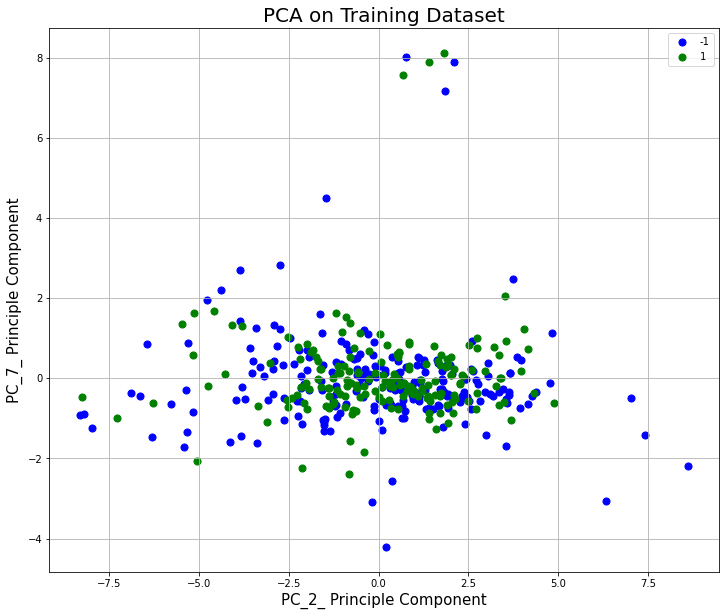

In [47]:
# Visualize Principle Components with Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1,1,1)
col_1 = "PC_2" # choose principle component 1
col_2 = "PC_7" # choose principle component 2
ax.set_xlabel(f"{col_1}_ Principle Component", fontsize=15)
ax.set_ylabel(f"{col_2}_ Principle Component", fontsize=15)
ax.set_title("PCA on Training Dataset", fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1],
               df_pca.loc[indices_to_keep, col_2],
               c = color,
               s=50)
ax.legend(targets)
ax.grid()

 ### Supervised ML - Random Forest Classification

In [54]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.565582371458552
Test Precision: 0.5308056872037915


In [49]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.3887724 , 0.6112276 ],
       [0.6426075 , 0.3573925 ],
       [0.49879013, 0.50120987],
       ...,
       [0.52807215, 0.47192785],
       [0.51966603, 0.48033397],
       [0.54058288, 0.45941712]])

In [50]:
# Test for Overfitting
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

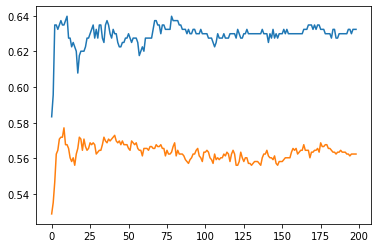

In [51]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()